In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
sns.set_style('whitegrid')
import folder_handling as fh
import os
import glob
from collections import OrderedDict
import matplotlib.pyplot as plt
import cv2

In [3]:
path = "../../images/color_experiments/experiment_3/no_lightening/"

In [4]:
def load_images(path,type_to_load="train"):
    path_indicators = fh.get_path_contents(path)
    
    data = OrderedDict()
    for pi in path_indicators:
        data[os.path.basename(pi)] = OrderedDict()
        
        for illum in fh.get_path_contents(pi):
            data[os.path.basename(pi)][os.path.basename(illum)] = OrderedDict()
            for gradation in fh.get_path_contents(os.path.join(illum,type_to_load)):
                img = cv2.imread(gradation)
                img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                name = os.path.splitext(os.path.basename(gradation))[0]
                data[os.path.basename(pi)][os.path.basename(illum)][name] = img
                
    return data

In [5]:
data_train = load_images(path)

In [6]:
data_test = load_images(path,type_to_load="test")

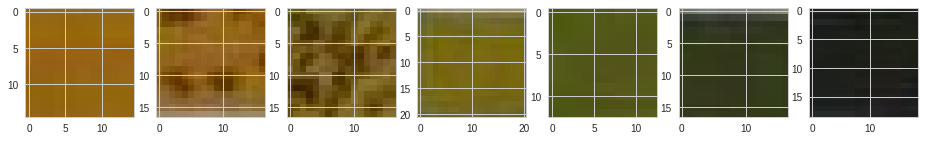

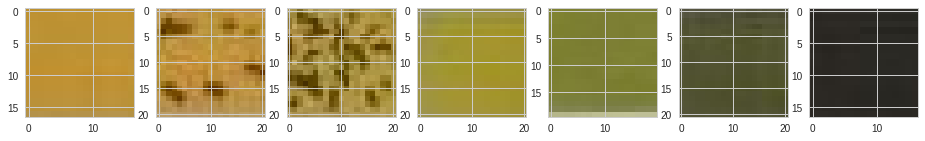

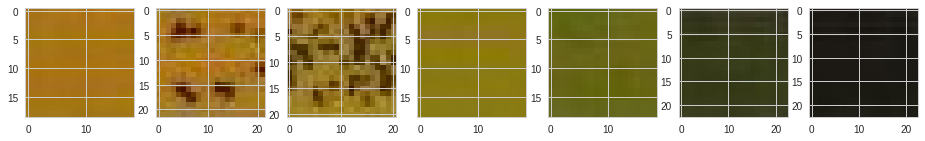

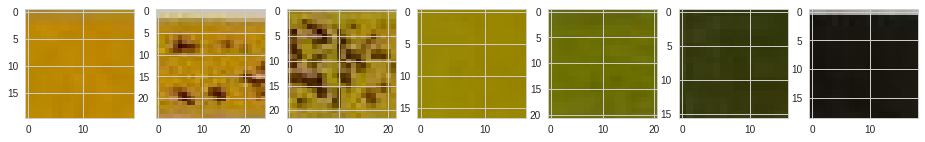

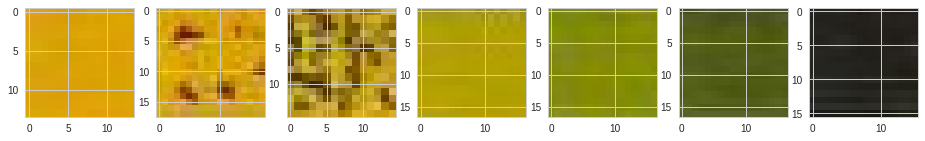

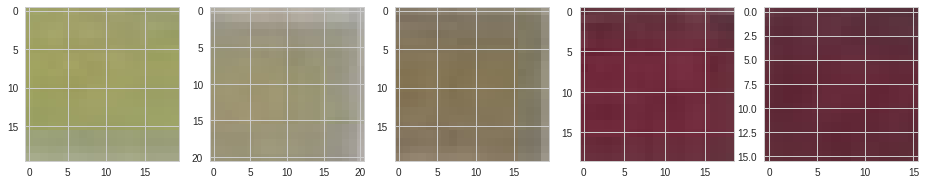

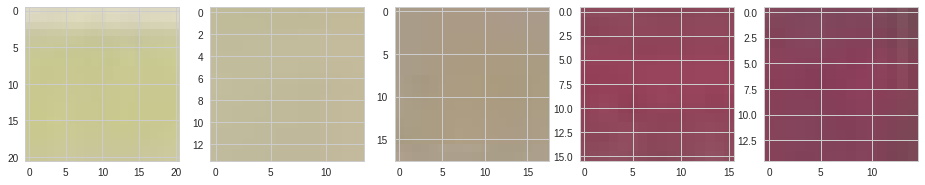

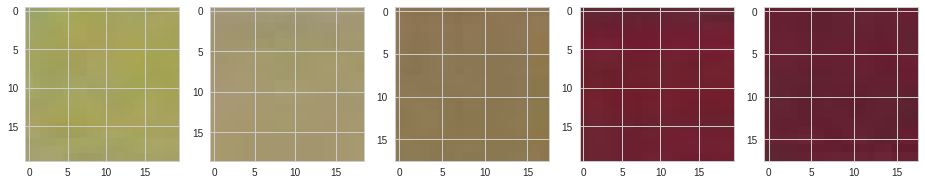

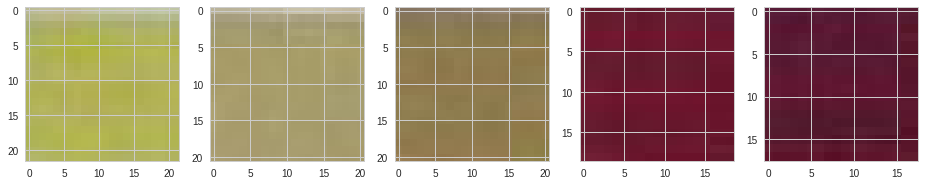

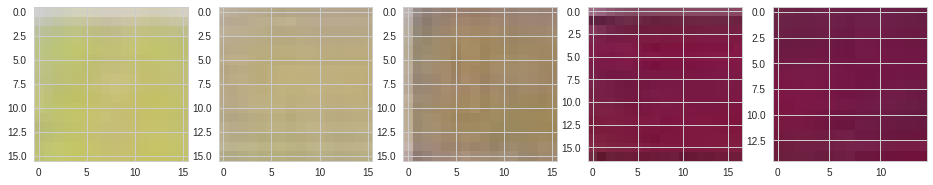

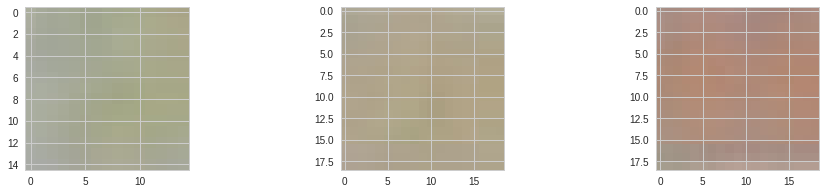

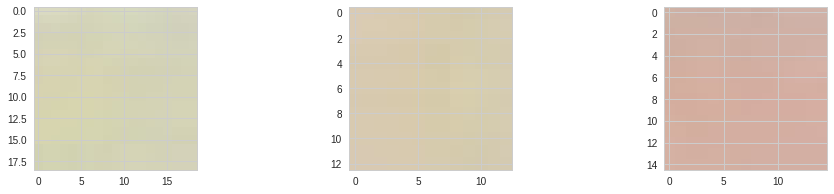

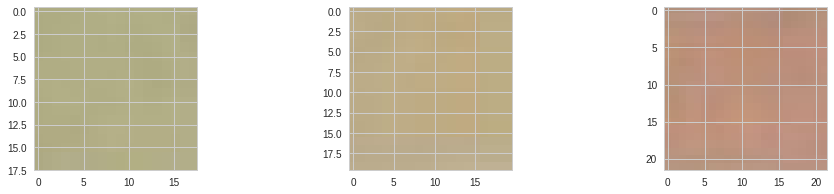

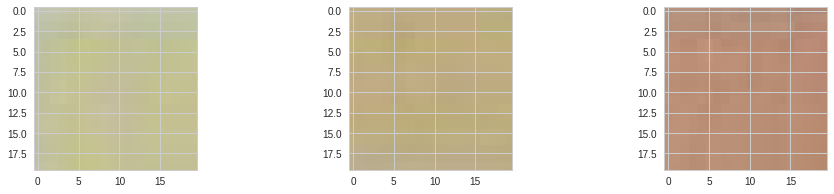

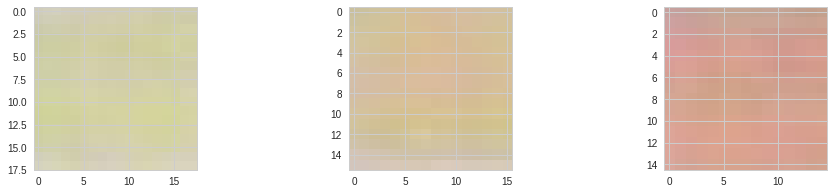

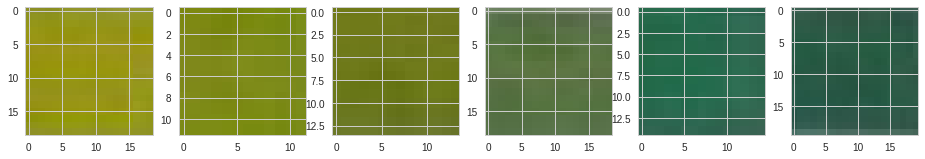

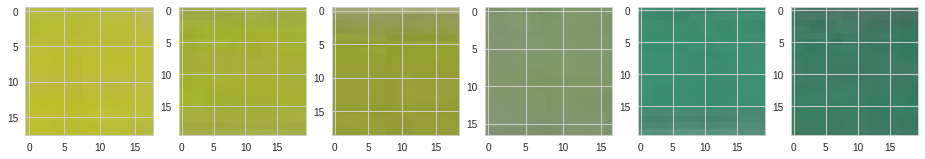

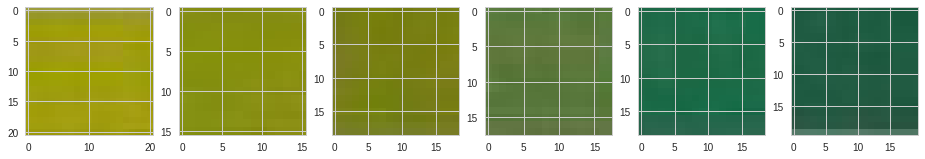

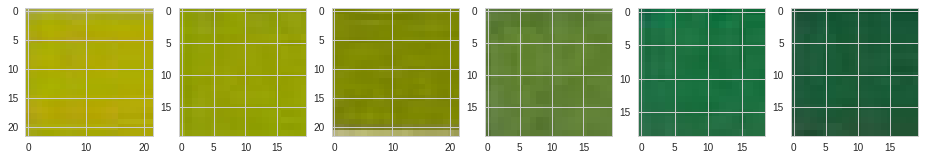

In [ ]:
for ind_type in data_train:
    for illumination_name,images in data_train[ind_type].iteritems():
        plt.figure(figsize=(16,3))
        for i,img in enumerate(images.values()):
            plt.subplot(1,len(images),i+1)
            plt.imshow(img)
            plt.axis('off')
        
        plt.suptitle('{} {} train'.format(ind_type,illumination_name))
        
        plt.figure(figsize=(16,3))
        images_test = data_test[illumination_name][ind_type]:
        for i,img in enumerate(images_test.values()):
            plt.subplot(1,len(images_test),i+1)
            plt.imshow(img)
            plt.axis('off
        plt.suptitle('{} {} test'.format(ind_type,illumination_name))

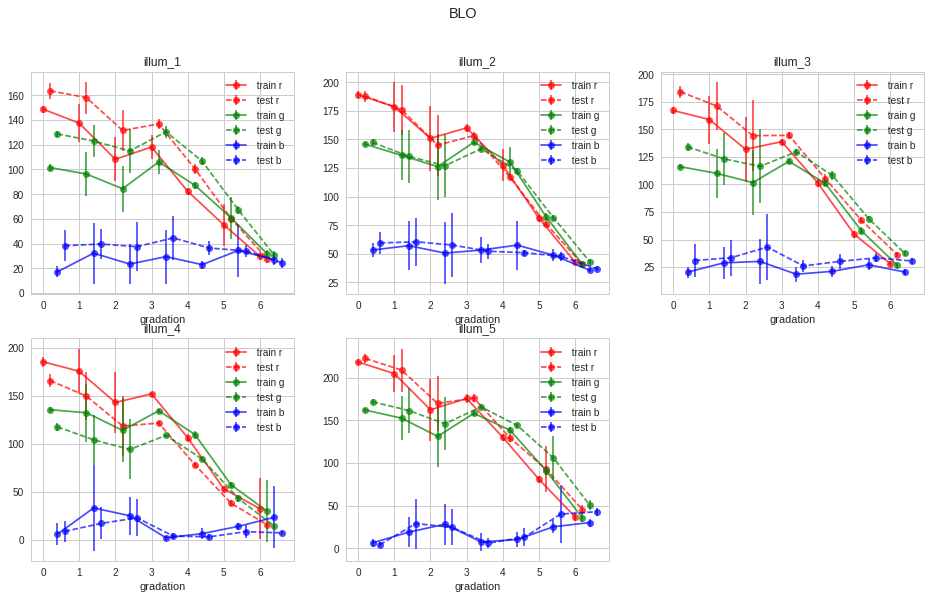

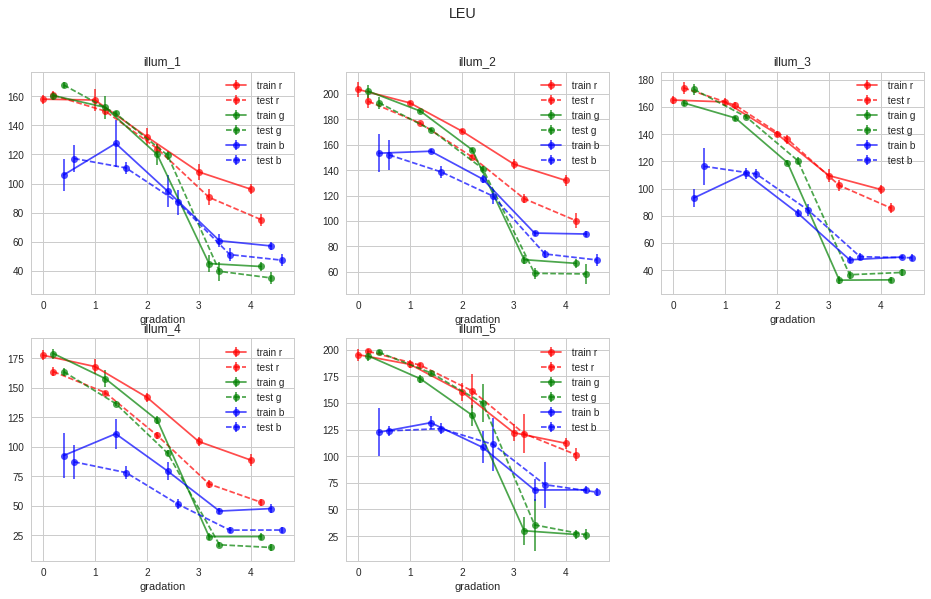

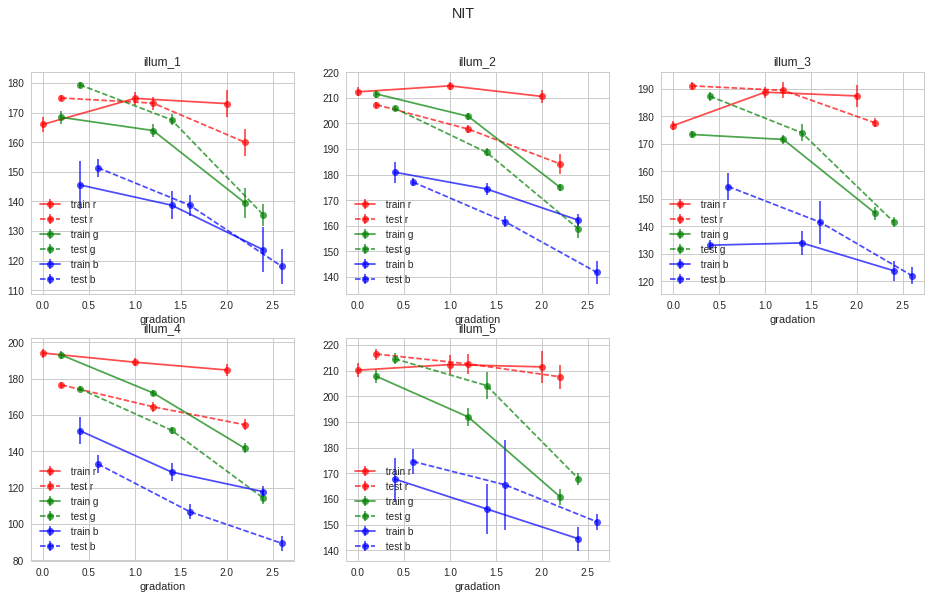

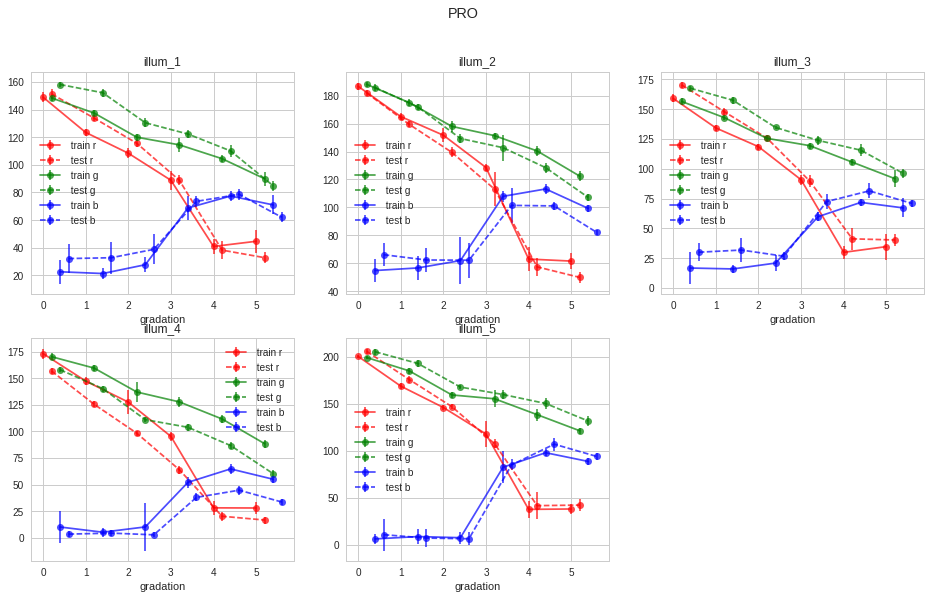

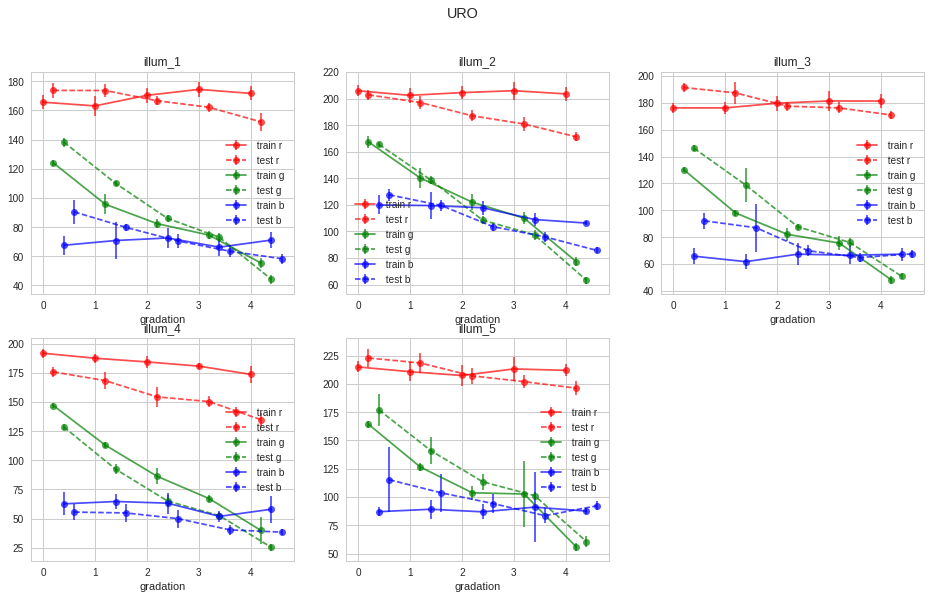

In [77]:
colors = ['r','g','b']
for inds,illums in data_train.iteritems():
    
    plt.figure(figsize=(16,9))
    illums_test = data_test[inds]
    for j,(illum_name,illum) in enumerate(illums.iteritems()):
        illum_test = illums_test[illum_name]
        plt.subplot(2,len(illums)//2 + 1,j+1)
        

        for i in xrange(3):
            values_train = [img.mean(axis=(0,1))[i] for img in illum.values()]
            stds_train = [img.std(axis=(0,1))[i] for img in illum.values()]
            xs_train = np.arange(0.2*i,len(values_train) + 0.2*i,1.)
            
            plt.errorbar(xs_train,values_train,stds_train,fmt='o-',c=colors[i],
                         label=" train {}".format(colors[i]),alpha=0.7)
            
            values_test = [img.mean(axis=(0,1))[i] for img in illum_test.values()]
            stds_test = [img.std(axis=(0,1))[i] for img in illum_test.values()]
            xs_test = np.arange(0.2*(i+1),len(values_test) + 0.2*(i+1),1.)
            
            plt.errorbar(xs_test,values_test,stds_test,fmt='o--',c=colors[i],
                         label=" test {}".format(colors[i]),alpha=0.7)
            
            plt.xlabel('gradation')
        plt.legend()
        plt.title(illum_name)
        
    plt.suptitle(inds)

In [198]:
 def get_distance(point1,point2):
        d = 0.
        for i in xrange(point1.shape[0]):
            d += (point1[i] - point2[i])**2
        return np.sqrt(d)
    

def one_nearest_neighbor(data_train,indicator_type,
                         illumination_name,test_img,verbose=False):
    INF_DISTANCE  = 255*3 + 1
    point_test = test_img.mean(axis=(0,1))

   
    min_dist = INF_DISTANCE
    predicted_class = None

    for class_name,trained_img in data_train[indicator_type][illumination_name].iteritems():
        point_train = trained_img.mean(axis=(0,1))

        dist = get_distance(point_test,point_train)
            
        if dist <= min_dist:
            min_dist = dist
            predicted_class = class_name

        if verbose:
            print "Current train class:",class_name
            print "Current distance:",dist

            print "Minimal distance is",min_dist
            print "Current predicted class is",predicted_class
            
            print "Test point coordinates",point_test
            print "Train point coordinates",point_train
            print
            
            
    return predicted_class

In [199]:

indicator_type = 'BLO'
illumination_name = 'illum_3'
true_class = '3'
test_img = data_test[indicator_type][illumination_name][true_class]

In [200]:
mistakes = []
all_results = []
for indicator_type in data_test:
    for illumination in data_test[indicator_type]:
        for true_class in data_test[indicator_type][illumination]:
            test_img = data_test[indicator_type][illumination_name][true_class]
            pred_val = one_nearest_neighbor(data_train,indicator_type=indicator_type,
                                illumination_name=illumination,
                                test_img=test_img,verbose=True)
        
            print "\n==========="
            print "True class is", true_class
            print "Predicted class is",pred_val

            print "true_class == pred_val:", true_class == pred_val

            all_results.append(true_class == pred_val)

   
            if pred_val != true_class:
                mistakes.append((indicator_type,illumination,true_class,pred_val))
                print "\n added to mistakes"
                
            print"\n\n\n"

Current train class: 1
Current distance: 50.1377253582
Minimal distance is 50.1377253582
Current predicted class is 1
Test point coordinates [ 184.22495274  134.11342155   30.90548204]
Train point coordinates [ 148.76888889  101.43555556   17.16444444]

Current train class: 2
Current distance: 60.2220704222
Minimal distance is 50.1377253582
Current predicted class is 1
Test point coordinates [ 184.22495274  134.11342155   30.90548204]
Train point coordinates [ 137.42214533   96.23875433   32.21107266]

Current train class: 3
Current distance: 91.2245109327
Minimal distance is 50.1377253582
Current predicted class is 1
Test point coordinates [ 184.22495274  134.11342155   30.90548204]
Train point coordinates [ 108.16262976   84.3183391    23.3633218 ]

Current train class: 4
Current distance: 71.8763582575
Minimal distance is 50.1377253582
Current predicted class is 1
Test point coordinates [ 184.22495274  134.11342155   30.90548204]
Train point coordinates [ 118.07256236  106.04535147 

In [196]:
all_results = np.array(all_results)

In [197]:
np.sum(all_results)/float(len(all_results))

0.59230769230769231

In [186]:
for item in mistakes:
    print ind_type, illum,true_class,_
    test_img = data_test[ind_type][illum][true_class]
    pred_val = one_nearest_neighbor(data_train,indicator_type=ind_type,
                                illumination_name=illum,
                                test_img=test_img, verbose=True)
    
    print "\n==========="
    print "True class is", true_class
    print "Predicted class is",pred_val
    
    print "true_class == pred_val:", true_class == pred_val
    
    print"\n\n\n"
    
   

BLO illum_1 2 1
Current train class: 1
Current distance: 32.4133642067
Minimal distance is 32.4133642067
Current predicted class is 1
Test point coordinates [ 158.06790123  122.93209877   39.57098765]
Train point coordinates [ 148.76888889  101.43555556   17.16444444]

Current train class: 2
Current distance: 34.5391114968
Minimal distance is 32.4133642067
Current predicted class is 1
Test point coordinates [ 158.06790123  122.93209877   39.57098765]
Train point coordinates [ 137.42214533   96.23875433   32.21107266]

Current train class: 3
Current distance: 65.1478855306
Minimal distance is 32.4133642067
Current predicted class is 1
Test point coordinates [ 158.06790123  122.93209877   39.57098765]
Train point coordinates [ 108.16262976   84.3183391    23.3633218 ]

Current train class: 4
Current distance: 44.5888390279
Minimal distance is 32.4133642067
Current predicted class is 1
Test point coordinates [ 158.06790123  122.93209877   39.57098765]
Train point coordinates [ 118.0725623